## Sinh dataset:
Dataset gồm 4 lớp: Cirlce, Square, Triangle, Diamond phục vụ cho bài toán phân loại

In [4]:
import cv2
import numpy as np
import os
import random

OUTPUT_DIR = "Shapes"
os.makedirs(OUTPUT_DIR, exist_ok=True)

img_size = 28
num_per_class = 250

def random_position_and_size():
    size = random.randint(8, 14)  # nhỏ hơn vì ảnh 28x28
    x = random.randint(3, img_size - size - 3)
    y = random.randint(3, img_size - size - 3)
    return x, y, size

# --- Drawing functions ---
def draw_square(img):
    x, y, size = random_position_and_size()
    cv2.rectangle(img, (x, y), (x + size, y + size), 255, -1)

def draw_circle(img):
    x, y, size = random_position_and_size()
    radius = size // 2
    cv2.circle(img, (x + radius, y + radius), radius, 255, -1)

def draw_triangle(img):
    x, y, size = random_position_and_size()
    pt1 = (x + size//2, y)
    pt2 = (x, y + size)
    pt3 = (x + size, y + size)
    pts = np.array([pt1, pt2, pt3], np.int32)
    cv2.fillPoly(img, [pts], 255)

def draw_diamond(img):
    x, y, size = random_position_and_size()
    cx = x + size//2
    cy = y + size//2
    pts = np.array([
        (cx, y),
        (x + size, cy),
        (cx, y + size),
        (x, cy)
    ], np.int32)
    cv2.fillPoly(img, [pts], 255)

# Map class to function
shape_drawers = {
    "Square": draw_square,
    "Circle": draw_circle,
    "Triangle": draw_triangle,
    "Diamond": draw_diamond
}

# --- Generate dataset ---
for shape_name, drawer in shape_drawers.items():
    shape_dir = os.path.join(OUTPUT_DIR, shape_name)
    os.makedirs(shape_dir, exist_ok=True)

    for i in range(num_per_class):
        img = np.zeros((img_size, img_size), dtype=np.uint8)
        drawer(img)

        filename = os.path.join(shape_dir, f"{shape_name}_{i}.png")
        cv2.imwrite(filename, img)

    print(f"Created {num_per_class} images for {shape_name}")

print("\nDone! Dataset saved in 'Shapes/'")


Created 250 images for Square
Created 250 images for Circle
Created 250 images for Triangle
Created 250 images for Diamond

Done! Dataset saved in 'Shapes/'


## Tạo và train model CNN tương tự

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

# -------------------------
# 1) Load dataset from folder
# -------------------------
img_size = 28
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    "Shapes",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=batch_size,
    subset="training"
)

val_gen = datagen.flow_from_directory(
    "Shapes",
    target_size=(img_size, img_size),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=batch_size,
    subset="validation"
)

print("Class mapping:", train_gen.class_indices)

# -------------------------
# 2) Build a simple CNN model
# -------------------------

model = models.Sequential([
    layers.Input(shape=(28, 28, 1)),

    layers.Conv2D(16, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')   # 4 classes
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# -------------------------
# 3) Train model
# -------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

# -------------------------
# 4) Save model to file
# -------------------------
model.save("cnn_shape.h5")
print("Model saved as cnn_shape.h5")


Found 800 images belonging to 4 classes.
Found 200 images belonging to 4 classes.
Class mapping: {'Circle': 0, 'Diamond': 1, 'Square': 2, 'Triangle': 3}


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,324 (220.02 KB)

 Trainable params: 56,324 (220.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/Users/nguyenduchuy/CodeHTTM/XLA/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3900 - loss: 1.3022 - val_accuracy: 0.5000 - val_loss: 1.1447
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6125 - loss: 0.9724 - val_accuracy: 0.6900 - val_loss: 0.7886
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7900 - loss: 0.6287 - val_accuracy: 0.8000 - val_loss: 0.5475
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8950 - loss: 0.3978 - val_accuracy: 0.9250 - val_loss: 0.3108
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9475 - loss: 0.2405 - val_accuracy: 0.9600 - val_loss: 0.2017
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9650 - loss: 0.1555 - val_accuracy: 0.9600 - val_loss: 0.1445
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9762 - loss: 0.1134 - val_accuracy: 0.9950 - val_loss: 0.0994
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9800 - loss: 0.0844 - val_accuracy: 0.9800 - val_loss: 0.0811
Epo

Model saved as cnn_shape.h5


## Test lại model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


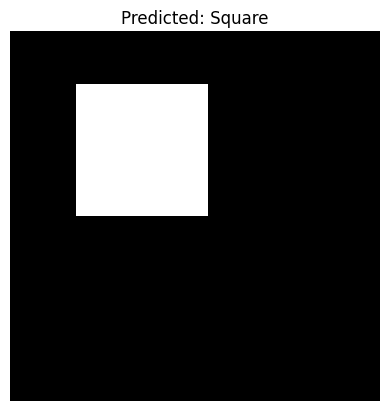

Image: Shapes/Square/Square_116.png
Prediction vector: [[4.6112277e-03 3.3388300e-08 9.9537295e-01 1.5777739e-05]]
Predicted class: Square
--------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


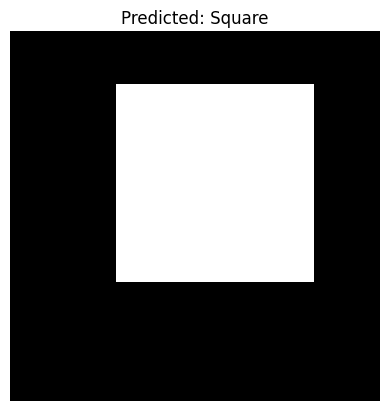

Image: Shapes/Square/Square_197.png
Prediction vector: [[3.2525802e-06 2.9977168e-16 9.9999678e-01 1.1546312e-10]]
Predicted class: Square
--------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


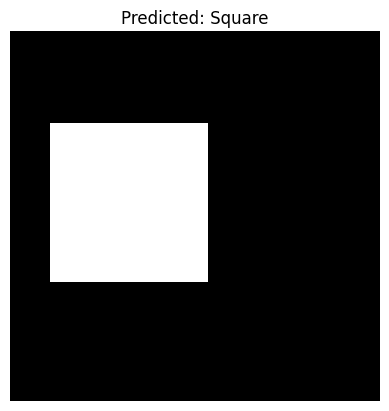

Image: Shapes/Square/Square_167.png
Prediction vector: [[9.6821255e-04 6.2405706e-11 9.9903131e-01 5.0483555e-07]]
Predicted class: Square
--------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


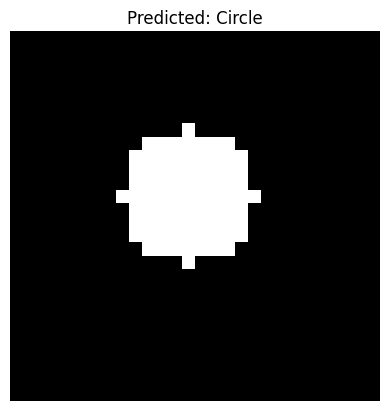

Image: Shapes/Circle/Circle_71.png
Prediction vector: [[0.992708   0.0011115  0.00139114 0.00478946]]
Predicted class: Circle
--------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


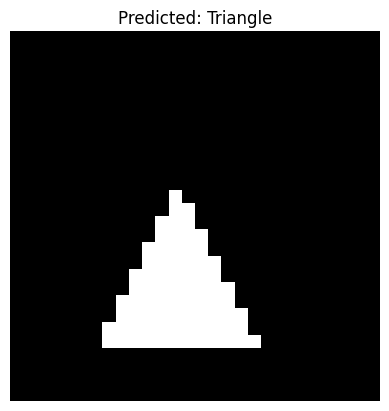

Image: Shapes/Triangle/Triangle_157.png
Prediction vector: [[2.3085771e-03 1.8480165e-05 8.2131206e-05 9.9759078e-01]]
Predicted class: Triangle
--------


In [7]:
import tensorflow as tf
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt

MODEL_PATH = "cnn_shape.h5"
DATASET_DIR = "Shapes"

# Load model
model = tf.keras.models.load_model(MODEL_PATH)

# Class mapping (phải giống lúc train)
class_names = ["Circle", "Diamond", "Square", "Triangle"]
# Lưu ý: mapping này phụ thuộc vào train_gen.class_indices
# Bạn có thể print(train_gen.class_indices) để chắc chắn thứ tự!

def get_random_image():
    # Chọn folder class bất kỳ
    class_folder = random.choice(os.listdir(DATASET_DIR))
    folder_path = os.path.join(DATASET_DIR, class_folder)
    
    # Chọn ảnh random trong folder đó
    img_name = random.choice(os.listdir(folder_path))
    img_path = os.path.join(folder_path, img_name)
    
    return img_path

def preprocess_image(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (28, 28))
    img_norm = img_resized / 255.0
    img_norm = img_norm.reshape(1, 28, 28, 1)
    return img, img_norm  # return both raw + preprocessed


# ----------- TEST LOOP -----------
for _ in range(5):   # test 5 ảnh random
    img_path = get_random_image()

    raw_img, input_img = preprocess_image(img_path)
    pred = model.predict(input_img)
    class_id = np.argmax(pred)
    class_name = class_names[class_id]

    # Plot
    plt.imshow(raw_img, cmap="gray")
    plt.title(f"Predicted: {class_name}")
    plt.axis("off")
    plt.show()

    print("Image:", img_path)
    print("Prediction vector:", pred)
    print("Predicted class:", class_name)
    print("--------")
